# Saegus Interview : Technical Project - Predicting Bike Rentals
---
<center><img src='test-technique.png' /></center>

## Overview 

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

We compiled a dataset like the one produced by [Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at [the University of Porto](http://www.up.pt/) which you'll be working with in this project. The file contains `62 608` rows, with each row representing the number of bike rentals for a single hour of a single day.

Here are the descriptions for the columns:

- `dteday` - The date of the rentals
- `hr` - rental's Hour
- `season` - The season in which the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `fulldate` - date and time (datetime format)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather
- `temp` - The temperature (°C)
- `atemp` - The adjusted temperature (°C)
- `hum` - The humidity (%)
- `windspeed` - The wind speed (km/h)
- `pressure` - Pressure (mb)
- `dewpoint` -  Temperature to which air must be cooled to become saturated with water vapor (in celsius).
- `fog` - Presence of fog (true/false).
- `wea_desc` - Description of the weather.
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (`casual` + `registered`)

## Instructions

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the `cnt` column and to accomplish this, you'll create machine learning model(s) and evaluate their performance.

But first, you will have to provide a clear data analysis on clean data.

Have Fun!

# Section 1. Analysis

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
matplotlib.get_backend()
%matplotlib inline
plt.style.use('seaborn')
import re


from sqlalchemy import create_engine

import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

import warnings
warnings.filterwarnings("ignore")

In [40]:
df = pd.read_csv('./bike_rental_hour_saegus.csv', sep=',')

* Dernier jour contient beaucoup de valeurs manquantes. Je le supprime car un jour sur 5 ans est négligeable.

In [41]:
# Supression du dernier jour qui contient des NaN
df = df[:-24]
df.shape

(52248, 18)

In [42]:
# Nettoyage des données
df['windspeed'] = df.windspeed.str.extract('(\d+)')
df['pressure'] = df.pressure.str.extract('(\d+)')
df['temp'] = df.temp.str.extract('(\d+)')
df['atemp'] = df.atemp.str.extract('(\d+)')
df['hum'] = df.hum.str.extract('(\d+)')
df['dewpoint'] = df.dewpoint.str.extract('(\d+)')

In [43]:
df.head()

,dteday,hr,casual,registered,cnt,season,holiday,fulldate,temp,atemp,dewpoint,hum,windspeed,pressure,weathersit,fog,wea_desc,workingday
0,2012-01-01,0,5,43,48,1,0,2012-01-01 00:00:00,9,8,3,66,9,1020,Clair,False,Dispersés Nuages à 1200m,False
1,2012-01-01,1,15,77,92,1,0,2012-01-01 01:00:00,7,7,3,76,2,1020,Clair,False,Peu de Nuages à 1200m,False
2,2012-01-01,2,16,57,73,1,0,2012-01-01 02:00:00,6,6,3,81,2,1020,Clair,False,Peu de Nuages à 1200m,False
3,2012-01-01,3,11,39,50,1,0,2012-01-01 03:00:00,5,4,2,81,6,1020,Clair,False,Peu de Nuages à 1200m,False
4,2012-01-01,4,0,8,8,1,0,2012-01-01 04:00:00,5,3,2,81,7,1020,Peu Nuageux,False,Claire moins de 3700m,False


In [44]:
# Colonnes inutiles car infos contenues dans d'autres
del df['fulldate']
del df['wea_desc']

In [45]:
df.weathersit.value_counts()

Clair                 15546
Très Nuageux          14250
Nuageux               13012
Peu Nuageux            4880
Pluie                  3802
Neige                   502
Tempete                 254
Brouillard Givrant        2
Name: weathersit, dtype: int64

In [46]:
df.fog.value_counts()

False    49504
True      2744
Name: fog, dtype: int64

* Encodage des variables

In [47]:
# Encodage des variables
df['weathersit'] = df['weathersit'].map({'Clair': 0, 'Très Nuageux': 1, 'Nuageux': 2, 
                                         'Peu Nuageux': 3, 'Pluie': 4, 'Neige': 5,
                                         'Tempete': 6, 'Brouillard Givrant': 7})

In [48]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['fog'])
df['fog'] = le.transform(df['fog'])
df['workingday'] = le.transform(df['workingday'])

* Transtypage des features

In [49]:
df['temp'] = df['temp'].astype(int)
df['atemp'] = df['atemp'].astype(int)
df['hum'] = df['hum'].astype(int)
df['windspeed'] = df['windspeed'].astype(int)
df['dewpoint'] = df['dewpoint'].astype(int)
df['pressure'] = df['pressure'].astype(int)

In [50]:
df.describe()

,hr,casual,registered,cnt,season,holiday,temp,atemp,dewpoint,hum,windspeed,pressure,weathersit,fog,workingday
count,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000,52248.000000
mean,11.527331,74.729195,265.453051,340.182246,2.509436,0.031140,15.790710,15.928629,11.048595,61.417394,13.533666,1017.678801,1.419576,0.052519,0.713635
std,6.916943,110.036416,268.026801,334.972707,1.112444,0.173698,9.174432,9.914362,6.902618,19.469563,7.774940,7.334075,1.294501,0.223073,0.452066
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,983.000000,0.000000,0.000000,0.000000
25%,6.000000,5.000000,56.000000,65.000000,2.000000,0.000000,8.000000,7.000000,5.000000,46.000000,7.000000,1013.000000,0.000000,0.000000,0.000000
50%,12.000000,28.000000,199.000000,248.000000,3.000000,0.000000,16.000000,16.000000,11.000000,61.000000,13.000000,1017.000000,1.000000,0.000000,1.000000
75%,18.000000,101.000000,376.000000,505.000000,3.000000,0.000000,23.000000,24.000000,17.000000,78.000000,19.000000,1022.000000,2.000000,0.000000,1.000000
max,23.000000,1037.000000,1639.000000,1988.000000,4.000000,1.000000,48.000000,46.000000,27.000000,100.000000,83.000000,1045.000000,7.000000,1.000000,1.000000


* Ne contient pas de valeurs abérrantes.

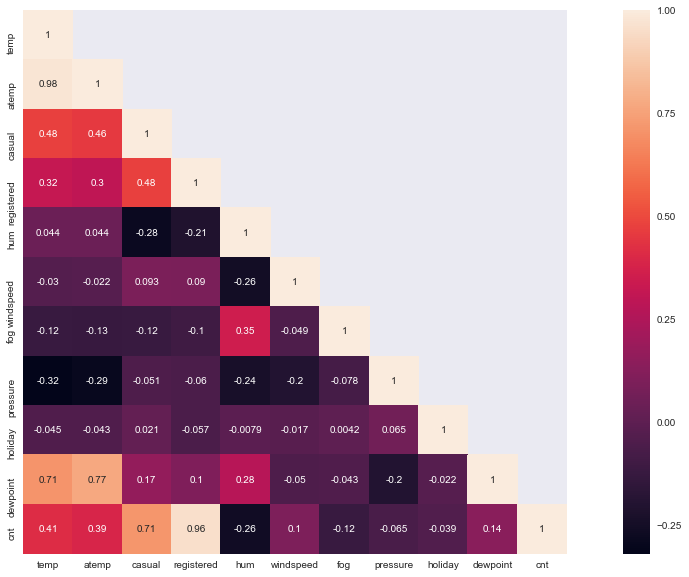

In [51]:
data_correlation = df[['temp', 'atemp', 'casual', 'registered', 'hum', 
                       'windspeed', 'fog', 'pressure', 'holiday', 'dewpoint', 'cnt']].corr()
mask = np.array(data_correlation)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(20,10))
sns.heatmap(data_correlation, mask=mask, vmax=1, square=True, annot=True)

* Les variables holiday, hum et fog ne sont que très peu corrélées avec la variable cnt à prédire.

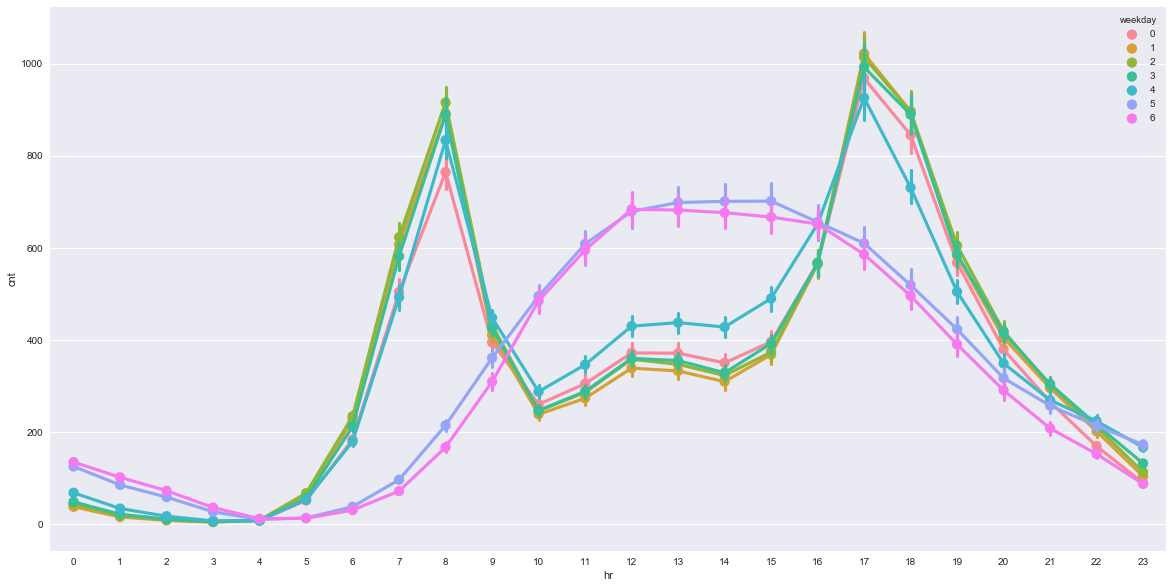

In [52]:
df['dteday'] = pd.to_datetime(df['dteday'], errors='coerce')
df['weekday'] = df['dteday'].dt.dayofweek
df['year'] = pd.DatetimeIndex(df['dteday']).year
df['month'] = pd.DatetimeIndex(df['dteday']).month

fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df[['hr',
                       'cnt',
                       'weekday']],
            x='hr', y='cnt',
            hue='weekday', ax=ax)

* Série temporelle trivariée : Nombre de vélos loués par heure et par jour de la semaine.

In [53]:
# Création d'un index date
df["dteday"] = pd.to_datetime(df["dteday"], errors="ignore", format="%Y/%m/%d")
df.set_index('dteday', inplace=True)

In [54]:
# Création des moyennes hebdomadaires
df_ts = df['cnt']
df_ts = df_ts.resample('W').mean()
df_ts = df_ts.dropna()

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_ts, model='additive')

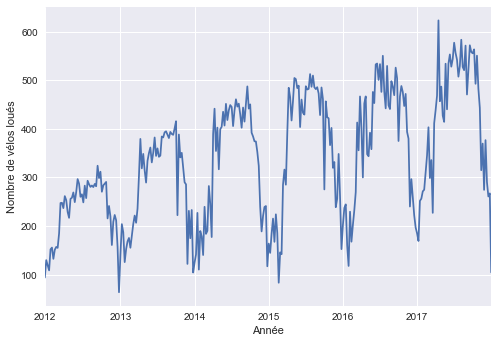

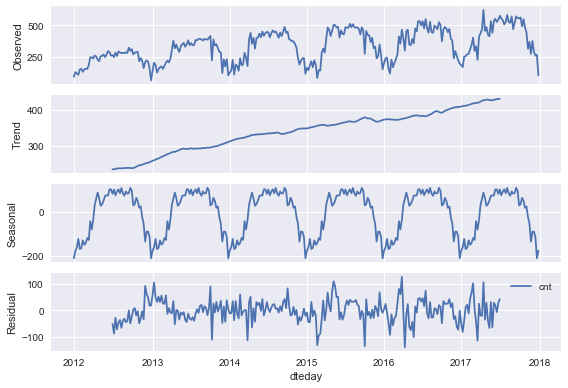

In [56]:
# De 2012 à 2018
ax = df_ts.plot()
ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2017-12-31'))
result.plot()

ax.set_xlabel(u'Année')
ax.set_ylabel(u'Nombre de vélos loués')

plt.axis()
plt.legend()
plt.show()

* L'année semble être une variable intéressante car on observe une nette augmentation du nombre de vélos loués d'année en année.

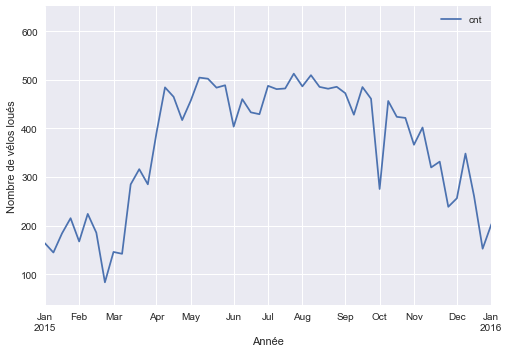

In [57]:
# Sur l'année 2015
ax = df_ts.plot()
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-12-31'))

ax.set_xlabel(u'Année')
ax.set_ylabel(u'Nombre de vélos loués')

plt.axis()
plt.legend()
plt.show()

* Moyenne du nombre de vélos loués par semaine en 2015

In [58]:
df2 = df[['cnt', 'hr']]
df2.set_index('hr', inplace=True)
# Création des moyennes de vélos loués par heure dans une journée.
df2 = df2.groupby(['hr'])['cnt'].mean()
df2 = df2.dropna()

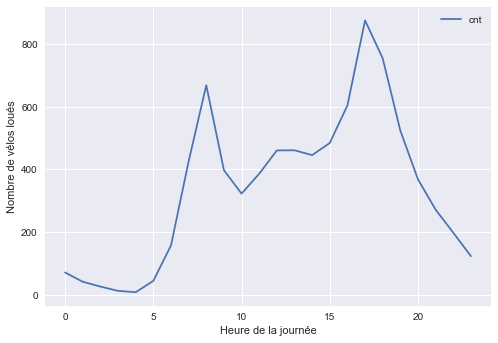

In [59]:
# Moyenne du nombre de locations de vélos par heure en une journée.
ax = df2.plot()

ax.set_xlabel(u'Heure de la journée')
ax.set_ylabel(u'Nombre de vélos loués')

plt.axis()
plt.legend()
plt.show()

* Nombre moyen de vélos loués dans une journée. On observe 2 pics logique entre 8 et 9h et 17-18h  qui correspondent aux heures de pointes pour aller au travail ou à ses occupations quotidiennes.

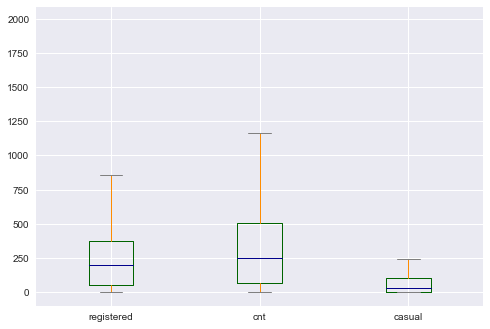

In [60]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
             medians='DarkBlue', caps='Gray')
df_box_plot = df[['registered', 'cnt', 'casual']]
df_box_plot.plot.box(color=color, sym='r+')

* Les variables casual et registered contiennent la réponse de la variable à prédire il faut donc les enlever pour entrainer le modèle.

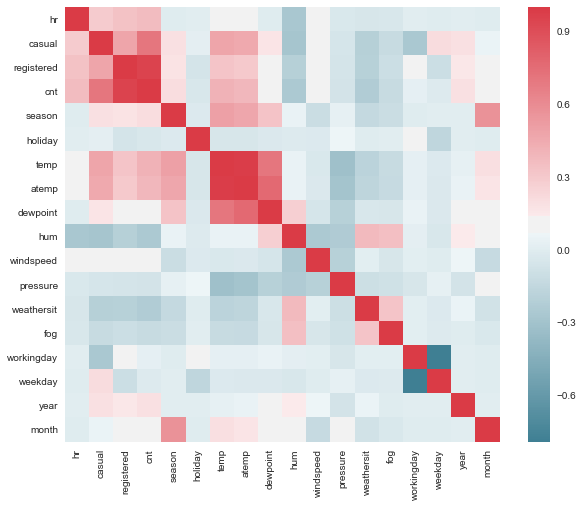

In [61]:
# Etude des corrélations entre les features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [62]:
# Suppression des variable casual et registered
del df['casual']
del df['registered']

In [63]:
df['lcnt'] = np.log(df.cnt)
# Définition d'une fonction générique
def make_histo(var):
    fig = plt.figure(figsize=(8,6))
    sns.distplot(var)
    ax.set_ylabel(u"Fréquence")
    ax.set_xlabel(u"cnt")
    plt.show()

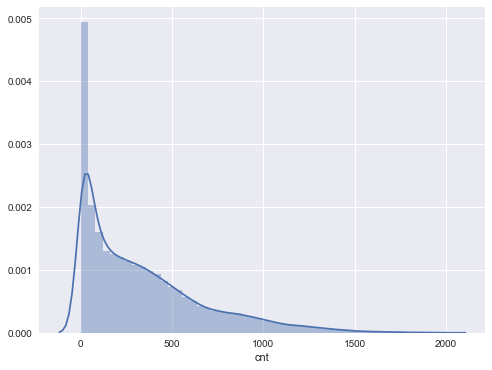

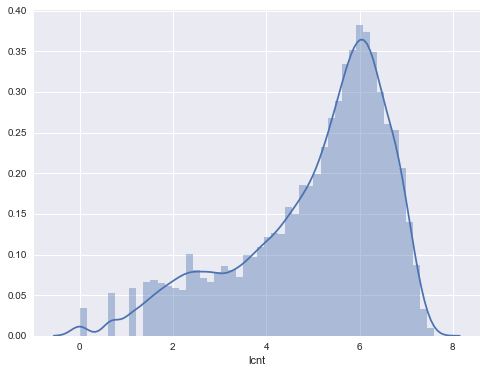

In [64]:
make_histo(df['cnt'])
make_histo(df['lcnt'])

* Le nombre de vélos loués par heure a une distribution log-normale : en effet, par une tranformation en log, on obtient une distribution d'une loi normale.

# Section 2. Prediction

In [65]:
data_dummy = df

def dummify_dataset(df, column):       
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)
    df = df.drop([column], axis=1)
    return df

columns_to_dummify = ['season', 'month', 'hr', 'holiday', 'weekday', 'year', 'workingday', 'weathersit']
for column in columns_to_dummify:
    data_dummy = dummify_dataset(data_dummy, column)
    
print data_dummy.columns
print('')
print len(data_dummy.columns)
print('')
data_dummy.head()

Index([u'cnt', u'temp', u'atemp', u'dewpoint', u'hum', u'windspeed',
       u'pressure', u'fog', u'lcnt', u'season_2', u'season_3', u'season_4',
       u'month_2', u'month_3', u'month_4', u'month_5', u'month_6', u'month_7',
       u'month_8', u'month_9', u'month_10', u'month_11', u'month_12', u'hr_1',
       u'hr_2', u'hr_3', u'hr_4', u'hr_5', u'hr_6', u'hr_7', u'hr_8', u'hr_9',
       u'hr_10', u'hr_11', u'hr_12', u'hr_13', u'hr_14', u'hr_15', u'hr_16',
       u'hr_17', u'hr_18', u'hr_19', u'hr_20', u'hr_21', u'hr_22', u'hr_23',
       u'holiday_1', u'weekday_1', u'weekday_2', u'weekday_3', u'weekday_4',
       u'weekday_5', u'weekday_6', u'year_2013', u'year_2014', u'year_2015',
       u'year_2016', u'year_2017', u'workingday_1', u'weathersit_1',
       u'weathersit_2', u'weathersit_3', u'weathersit_4', u'weathersit_5',
       u'weathersit_6', u'weathersit_7'],
      dtype='object')

66



,cnt,temp,atemp,dewpoint,hum,windspeed,pressure,fog,lcnt,season_2,...,year_2016,year_2017,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weathersit_5,weathersit_6,weathersit_7
dteday,,,,,,,,,,,,,,,,,,,,,
2012-01-01,48,9,8,3,66,9,1020,0,3.871201,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-01,92,7,7,3,76,2,1020,0,4.521789,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-01,73,6,6,3,81,2,1020,0,4.290459,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-01,50,5,4,2,81,6,1020,0,3.912023,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-01,8,5,3,2,81,7,1020,0,2.079442,0,...,0,0,0,0,0,1,0,0,0,0


* Dummy variables pour rendre les variables de météo et de date catégorielles. Cela aura un impact sur le résultat.

In [66]:
data_dummy = data_dummy.reset_index()

In [67]:
data_dummy.index = data_dummy.dteday

In [68]:
del data_dummy['dteday']

In [69]:
# Split des data
y = data_dummy['cnt']
X = data_dummy.copy()
del X['cnt']
del X['lcnt']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

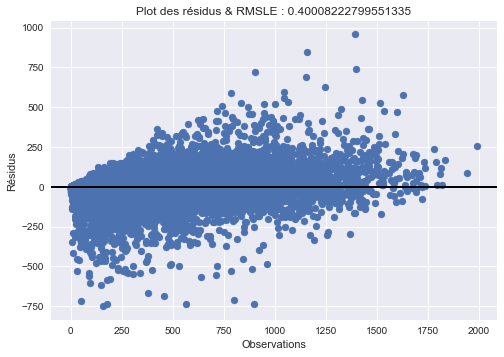

In [76]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor

    
extree = ExtraTreesRegressor()
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)

# Plot the residuals
residuals = y_test-y_pred

fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel(u'Observations')
ax.set_ylabel(u'Résidus')
ax.title.set_text(u'Plot des résidus & RMSLE : ' 
                  + str(np.sqrt(mean_squared_log_error(y_test, y_pred))))
plt.show()

In [77]:
importances = extree.feature_importances_
std = np.std([extree.feature_importances_ for extree in extree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Affichage dans l'ordre des features importantes
print("Features :")

for i in range(0, len(X_train.columns)):
    print(i + 1, X_train.columns[i])

print("\n")
print("Features importances rankées:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Features :
(1, 'temp')
(2, 'atemp')
(3, 'dewpoint')
(4, 'hum')
(5, 'windspeed')
(6, 'pressure')
(7, 'fog')
(8, 'season_2')
(9, 'season_3')
(10, 'season_4')
(11, 'month_2')
(12, 'month_3')
(13, 'month_4')
(14, 'month_5')
(15, 'month_6')
(16, 'month_7')
(17, 'month_8')
(18, 'month_9')
(19, 'month_10')
(20, 'month_11')
(21, 'month_12')
(22, 'hr_1')
(23, 'hr_2')
(24, 'hr_3')
(25, 'hr_4')
(26, 'hr_5')
(27, 'hr_6')
(28, 'hr_7')
(29, 'hr_8')
(30, 'hr_9')
(31, 'hr_10')
(32, 'hr_11')
(33, 'hr_12')
(34, 'hr_13')
(35, 'hr_14')
(36, 'hr_15')
(37, 'hr_16')
(38, 'hr_17')
(39, 'hr_18')
(40, 'hr_19')
(41, 'hr_20')
(42, 'hr_21')
(43, 'hr_22')
(44, 'hr_23')
(45, 'holiday_1')
(46, 'weekday_1')
(47, 'weekday_2')
(48, 'weekday_3')
(49, 'weekday_4')
(50, 'weekday_5')
(51, 'weekday_6')
(52, 'year_2013')
(53, 'year_2014')
(54, 'year_2015')
(55, 'year_2016')
(56, 'year_2017')
(57, 'workingday_1')
(58, 'weathersit_1')
(59, 'weathersit_2')
(60, 'weathersit_3')
(61, 'weathersit_4')
(62, 'weathersit_5')
(63, 'weat

* Les variables les plus importantes sont 17h-18h et 8h, la température et journée de travail.

In [72]:
y_pred = pd.DataFrame(y_pred)

print("5 premiers y prédits : ")
print(y_pred.tail(20))
print("\n")
print("5 premiers y vrais : ")
print(y_test.tail(20))

5 premiers y prédits : 
                 0
15655    55.800000
15656   526.500000
15657   350.900000
15658   171.100000
15659   329.266667
15660   174.300000
15661    12.300000
15662   292.700000
15663   487.800000
15664   317.300000
15665   144.500000
15666    74.900000
15667   168.400000
15668   258.000000
15669   188.400000
15670    47.500000
15671   205.300000
15672    68.800000
15673    46.000000
15674  1624.300000


5 premiers y vrais : 
dteday
2016-01-20      44
2015-07-24     644
2015-06-22     327
2012-07-08     146
2017-11-15     389
2015-01-13     174
2013-05-05       9
2014-12-18     408
2015-06-13     606
2016-05-03     160
2013-02-19     103
2012-01-31      63
2013-01-14     135
2014-12-29     298
2014-05-23     177
2013-06-10      35
2013-02-07     242
2017-01-11      53
2017-04-08      34
2017-05-03    1713
Name: cnt, dtype: int64


In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("Number of predictions:",len(y_pred))

meanSquaredError=mean_squared_error(y_test, y_pred)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

('Number of predictions:', 15675)
('RMSE:', 89.57093856696473)


In [74]:
print 'RMSLE = ', rmsle(np.array(y_pred).ravel(), y_test)

RMSLE =  0.39757292311406417


### R-carré
R-carré est une mesure statistique de la proximité des données par rapport à la droite de régression ajustée. Il est également connu comme le coefficient de détermination, ou le coefficient de détermination multiple pour la régression multiple.

La définition de R-carré est assez simple; c'est le pourcentage de la variance de la variable de réponse qui est expliqué par un modèle linéaire. Où :

R-carré = Variance expliquée / Variance totale

R-carré est toujours entre 0 et 100%:

0% indique que le modèle n'explique pas la variabilité des données de réponse autour de sa moyenne.
100% indique que le modèle explique toute la variabilité des données de réponse autour de sa moyenne.
En général, plus le R-carré est élevé, plus le modèle correspond à vos données.

In [75]:
print('Le coefficient de détermination :')
r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

Le coefficient de détermination :


0.9281658925917132

* Il est proche de 1 ce qui signifie que le nuage de point est proche de la droite de régression.